# SST (Spatial Stress Test) Behavioral Analysis

Data Collected June 2015

In [3]:
import pandas as pd
import moss
from scipy import stats
import scipy as sp
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path as op
import re

#widget ability
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import clear_output, display, HTML

import glob

# Gather project info & functions
from sst_setup_project import *

# for plotting
sns.set(style='whitegrid', context='poster')
%matplotlib inline

# R for stats
# %load_ext rpy2.ipython
# %R require(lme4)
# %R require(lmerTest)

/Users/sgagnon/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/sgagnon/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/sgagnon/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Set up directories & exp-specific information

In [4]:
dirs = dict()
dirs['basedir'] = op.join(op.expanduser('~'), 'Experiments/SST')
dirs['navdir'] = op.join('/Volumes/group/awagner/sgagnon/SST/nav_data')
dirs['analydir'] = op.join(dirs['basedir'], 'analysis')
dirs['subj_info_file'] = op.join(dirs['basedir'], 'data', 'subj_info.csv')
dirs['shortcut_file'] = op.join(dirs['basedir'], 'data','shortcut_coords.csv')
dirs['order_file'] = op.join(dirs['basedir'], 'data','SST_env_order.csv')

In [5]:
proj = gather_experiment_info(exp_name='SST', dirs=dirs)

### Read in subject information

In [6]:
subj_info = pd.read_csv(dirs['subj_info_file'])
subj_info = subj_info[pd.isnull(subj_info.remove)]
subj_info[['subid']] = subj_info.subid.astype(str)
subj_info

,subid,group,remove
1,2,control,NaN
2,3,control,NaN
3,4,control,NaN
4,5,control,NaN
5,6,control,NaN
6,7,control,NaN
7,9,control,NaN
9,11,control,NaN
10,12,control,NaN


In [7]:
shortcut_coords = pd.read_csv(dirs['shortcut_file'])
shortcut_coords

,env,x_lo,x_hi,y_lo,y_hi
0,env1,16,32,5,15
1,env2,8,28,28,48
2,env3,24,40,16,24
3,env4,16,32,16,24
4,env5,12,20,20,31
5,env6,24,40,24,40
6,env7,10,15,30,40
7,env8,16,32,0,16
8,env9,24,35,0,12
9,env10,48,56,24,40


## Read in data files

In [8]:
trial_order = pd.read_csv(dirs['order_file'])
trial_order[['subid']] = trial_order[['subid']].astype(str)
trial_order.head()

,subid,rep,run,trial,env
0,1,1,1,1,1
1,1,1,1,2,8
2,1,1,1,3,9
3,1,1,2,1,4
4,1,1,2,2,5


In [9]:
df = pd.DataFrame() # dataframe of subjs x envs
test = True
questionnaires_shock  = False
questionnaires_post  = True

test_types = ['habit', 'shortcut']

# iterate through subjects
for subid in subj_info.subid:
    print subid
    
    if test:
        # iterate through environments
        for run_num in range(1, 12+1):

            if int(subid) < 10:
                # add test file
                test_file = glob.glob(op.join(dirs['navdir'], 'sst0' + str(subid), 'run'+ str(run_num),
                                    'session_*', 'log.txt'))[0]
            else:
                test_file = glob.glob(op.join(dirs['navdir'], 'sst' + str(subid), 'run'+ str(run_num),
                                    'session_*', 'log.txt'))[0]
                
#             print test_file 
            
            output = []
            with open(test_file) as f:
                data = f.readlines()

                for line in data:
                    columns = re.split('\t|\r|\n', line)
                    output.append(columns)
                    
            d2 = pd.DataFrame(output, columns = ['time', 'c2', 'command', 
                                                 'c3', 'c4', 'c5', 'c6', 'c7', 'c8'])

            # include subid and env
            d2['subid'] = subid
            d2['run'] = run_num
                        
            if run_num < 5:
                d2['type'] = 'habit'
            else:
                d2['type'] = 'shortcut'

            # force time to be integer, diff from end to beginning
            d2.time = d2.time.astype(int)
            d2.time = d2.time - d2.time.min()

            df = df.append(d2, ignore_index=True)
        
# Compiled group data
if questionnaires_shock:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_shockblock_group.csv')
    dq_shock = pd.read_csv(q_file, index_col=0)

if questionnaires_post:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_group.csv')
    dq_post = pd.read_csv(q_file, index_col=0)
    dq_post['subid'] = dq_post.subid.astype(str)

2
3
4
5
6
7
9
11
12


## Look at data

In [10]:
df.head()

,time,c2,command,c3,c4,c5,c6,c7,c8,subid,run,type
0,0,1,COMMON_WIN_PROPERTIES,800,600,True,False,,,2,1,habit
1,125,0,CAMERA_INIT,PandaEPL_defaultCamera,,,None,None,None,2,1,habit
2,125,0,VR_INIT,,,None,None,None,None,2,1,habit
3,125,0,VR_CREATED,,,None,None,None,None,2,1,habit
4,2175,0,CONF_LOAD,./config.py,None,,,None,None,2,1,habit


## Integrate env labels

#### Any runs without 3 trials?

In [11]:
counts = pd.groupby(df[df.command == "ORIENT"], by=['subid', 'run']).count().reset_index()
counts[counts.command != 3]

,subid,run,time,c2,command,c3,c4,c5,c6,c7,c8,type
1,11,2,1,1,1,1,1,1,1,1,1,1


In [12]:
orient_onsets = df[df.command == "ORIENT"]
orient_onsets.head()

,time,c2,command,c3,c4,c5,c6,c7,c8,subid,run,type
224,16545,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit
15045,111425,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit
22741,172355,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit
38400,16177,21,ORIENT,oriented_to_env,,,None,None,None,2,2,habit
48755,87177,11,ORIENT,oriented_to_env,,,None,None,None,2,2,habit


In [13]:
orient_onsets.index[1:]

Int64Index([15045, 22741, 38400, 48755, 58968, 72098, 83033, 98160, 111844, 125664, 141035, 155667, 168622, 175804, 187557, 200287, 213200, 222678, 231091, 235371, 246833, 258447, 269360, 276136, 286696, 291782, 296722, 306122, 311605, 317637, 326734, 335312, 344199, 357771, 368265, 376579, 393036, 408732, 423296, 444631, 457502, 478583, 505349, 523803, 543019, 562937, 582893, 601562, 611067, 620155, 632794, 639780, 649234, 657603, 681389, 688143, 697652, 707563, 715432, 730756, 738831, 747895, 757115, 762818, 772266, 779151, 786889, 793069, 800989, 808895, 813396, 822990, 838859, 850118, 866997, 883248, 895869, 906823, 919483, 931341, 943580, 956600, 975398, 1061508, 1071307, 1076279, 1080828, 1087087, 1092955, 1100369, 1108126, 1113830, 1120713, 1124502, 1130495, 1135220, 1141291, 1147508, 1153158, 1157642, ...], dtype='int64')

In [14]:
orient_onsets['trial'] = 0 # init trial number

for counter, ind in enumerate(orient_onsets.index):
    if counter == 0: # first trial
        first_ind = ind
        orient_onsets.ix[ind, 'trial'] = 1
        prev_ind = ind
    else:
        if orient_onsets.ix[ind, 'run'] == orient_onsets.ix[prev_ind, 'run']:
            orient_onsets.ix[ind, 'trial'] = orient_onsets.ix[prev_ind, 'trial'] + 1
            prev_ind = ind
        else:
            orient_onsets.ix[ind, 'trial'] = 1
            prev_ind = ind
        

/Users/sgagnon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/sgagnon/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [15]:
orient_onsets.head()

,time,c2,command,c3,c4,c5,c6,c7,c8,subid,run,type,trial
224,16545,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit,1
15045,111425,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit,2
22741,172355,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit,3
38400,16177,21,ORIENT,oriented_to_env,,,None,None,None,2,2,habit,1
48755,87177,11,ORIENT,oriented_to_env,,,None,None,None,2,2,habit,2


In [16]:
trial_order.head()

,subid,rep,run,trial,env
0,1,1,1,1,1
1,1,1,1,2,8
2,1,1,1,3,9
3,1,1,2,1,4
4,1,1,2,2,5


In [18]:
orient_onsets = orient_onsets.reset_index().merge(trial_order)
orient_onsets.head()

,index,time,c2,command,c3,c4,c5,c6,c7,c8,subid,run,type,trial,rep,env
0,224,16545,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit,1,1,1
1,15045,111425,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit,2,1,8
2,22741,172355,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit,3,1,9
3,38400,16177,21,ORIENT,oriented_to_env,,,None,None,None,2,2,habit,1,1,10
4,48755,87177,11,ORIENT,oriented_to_env,,,None,None,None,2,2,habit,2,1,2


In [19]:
df['env'] = np.nan
df['rep'] = np.nan
df['trial'] = np.nan

for i in orient_onsets.index:
    index_val = orient_onsets.loc[i, 'index']
    df.loc[index_val, 'env'] = 'env' + orient_onsets.loc[i, 'env'].astype(str)
    df.loc[index_val, 'rep'] = orient_onsets.loc[i, 'rep']
    df.loc[index_val, 'trial'] = orient_onsets.loc[i, 'trial']

df.env.fillna(method='ffill', inplace=True)
df.rep.fillna(method='ffill', inplace=True)
df.trial.fillna(method='ffill', inplace=True)

In [20]:
print len('env' + orient_onsets.env.astype(str))
print len(df.loc[orient_onsets['index'], 'env'])

322
322


### Look at 2D position in space

In [21]:
dp = df[df.command == 'VROBJECT_POS'].reset_index()
dp = dp.drop(['c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
dp.head()

,time,c2,c3,c4,subid,run,type,env,rep,trial
0,6525,1,terrain0,"LPoint3f(0, 0, 0)",2,1,habit,NaN,NaN,NaN
1,6525,1,George_Clooney,"LPoint3f(4, 34, 0.5)",2,1,habit,NaN,NaN,NaN
2,6525,1,lettuce,"LPoint3f(26, 52, 0.5)",2,1,habit,NaN,NaN,NaN
3,6525,1,zebra,"LPoint3f(20, 22, 0.5)",2,1,habit,NaN,NaN,NaN
4,6525,1,zzz,"LPoint3f(12, 52, 0.2)",2,1,habit,NaN,NaN,NaN


In [22]:
dp = dp.join(pd.DataFrame(dp.c4.str.split('Point3|, |\(|\)').tolist()).reindex(columns=[2, 3, 4]))
dp.rename(columns={2: 'x', 3: 'y', 4: 'z'}, inplace=True)
dp = dp.drop(['c4', 'c2'], 1)
dp[['x', 'y', 'z']] = dp[['x', 'y', 'z']].astype(float)
dp.head()

,time,c3,subid,run,type,env,rep,trial,x,y,z
0,6525,terrain0,2,1,habit,NaN,NaN,NaN,0,0,0.0
1,6525,George_Clooney,2,1,habit,NaN,NaN,NaN,4,34,0.5
2,6525,lettuce,2,1,habit,NaN,NaN,NaN,26,52,0.5
3,6525,zebra,2,1,habit,NaN,NaN,NaN,20,22,0.5
4,6525,zzz,2,1,habit,NaN,NaN,NaN,12,52,0.2


(<matplotlib.figure.Figure at 0x1464e2b50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1464e2910>)

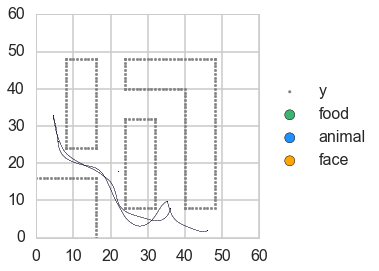

In [23]:
plot_paths(env='env1', subj='6', 
           dp=dp[dp['type'] == 'shortcut'], 
           proj=proj)

(<matplotlib.figure.Figure at 0x145871950>,
 <matplotlib.axes._subplots.AxesSubplot at 0x170fed650>)

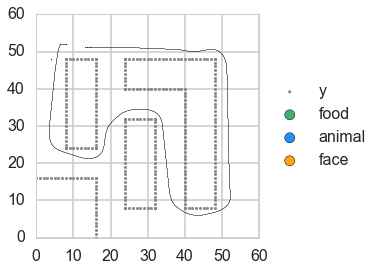

In [24]:
plot_paths(env='env1', subj='6', 
           dp=dp[dp['type'] == 'habit'], 
           proj=proj)

## Heading Direction

In [25]:
dh = df[(df.command == 'VROBJECT_HEADING') & (df.c3 == 'PandaEPL_avatar')].reset_index()
dh = dh.drop(['c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
dh.head()

,time,c2,c3,c4,subid,run,type,env,rep,trial
0,6525,1,PandaEPL_avatar,90.0,2,1,habit,NaN,NaN,NaN
1,17805,11,PandaEPL_avatar,135.0,2,1,habit,env1,1,1
2,19065,11,PandaEPL_avatar,180.0,2,1,habit,env1,1,1
3,20325,11,PandaEPL_avatar,225.0,2,1,habit,env1,1,1
4,21585,11,PandaEPL_avatar,270.0,2,1,habit,env1,1,1


### Look at data just for 1 sub in 1 env

In [26]:
dsub = dh.query('env == "env3" & subid=="2"')
dsub.head()

,time,c2,c3,c4,subid,run,type,env,rep,trial
16145,164209,1,PandaEPL_avatar,0.132919083786,2,3,habit,env3,1,3
16146,164209,11,PandaEPL_avatar,0.153662069375,2,3,habit,env3,1,3
16147,164219,11,PandaEPL_avatar,0.163073560118,2,3,habit,env3,1,3
16148,164239,11,PandaEPL_avatar,0.167945632728,2,3,habit,env3,1,3
16149,164249,21,PandaEPL_avatar,0.151855815384,2,3,habit,env3,1,3


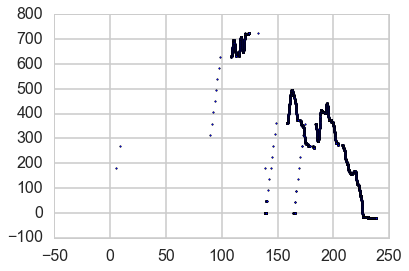

In [27]:
plt.scatter(dsub.time/1000, dsub.c4.astype(float), 
            s=10, marker='.')

In [28]:
df.ix[30:45, 'command']

30                  TASK_LASTRUN
31                  TASK_CREATED
32                 TASK_SCHEDULE
33                VR_INPUTLISTEN
34                  TASK_LASTRUN
35                      TASK_RUN
36       VROBJECT_STICKSTOSCREEN
37    VROBJECT_COLLISIONCALLBACK
38            CAMERA_ASPECTRATIO
39                    CAMERA_FOV
40                CAMERA_CREATED
41            CAMERA_ASPECTRATIO
42                    CAMERA_FOV
43       VROBJECT_STICKSTOSCREEN
44    VROBJECT_COLLISIONCALLBACK
45                  VROBJECT_POS
Name: command, dtype: object

## Text Events

In [29]:
dt = df[(df.command.isin(['ASSIGNED'])) 
        | df.command.isin(['ARRIVED'])].reset_index()
dt.ix[dt.command == 'ARRIVED', 'c3'] = 'between_trials'
dt = dt.drop(['c2', 'c4', 'c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
dt = dt.rename(columns={'c3': 'instructions'})
dt.head()

,time,instructions,subid,run,type,env,rep,trial
0,27585,zzz,2,1,habit,env1,1,1
1,97445,between_trials,2,1,habit,env1,1,1
2,122465,zzz,2,1,habit,env8,1,2
3,158375,between_trials,2,1,habit,env8,1,2
4,183385,zzz,2,1,habit,env9,1,3


In [30]:
dt['total_time'] = (dt.time - dt.time.shift(1)).shift(-1)
dt.head()

,time,instructions,subid,run,type,env,rep,trial,total_time
0,27585,zzz,2,1,habit,env1,1,1,69860
1,97445,between_trials,2,1,habit,env1,1,1,25020
2,122465,zzz,2,1,habit,env8,1,2,35910
3,158375,between_trials,2,1,habit,env8,1,2,25010
4,183385,zzz,2,1,habit,env9,1,3,58380


### Average time to navigate to goal

/Users/sgagnon/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


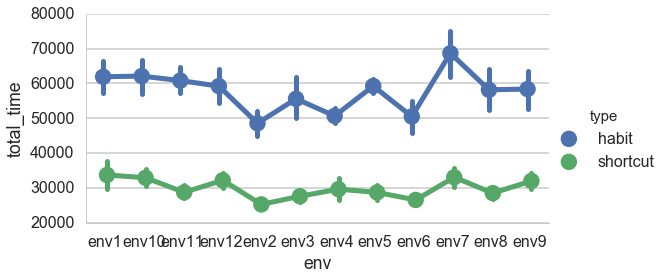

In [31]:
means = dt[dt.instructions != 'between_trials'].merge(subj_info).groupby(['subid', 'type', 'env']).mean().reset_index()
sns.factorplot(x='env', y='total_time', aspect=2, hue='type',
               units='subid', ci=68, dodge=.1,
               data=means)

## Input Events

In [32]:
di = df[(df.command == 'INPUT_EVENT')].reset_index()
di = di.drop(['c4', 'c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
di = di.query('(c3 != "dismiss") & (c3 != "exit")')
di.head()

,time,c2,c3,subid,run,type,env,rep,trial
0,36105,0,turnLeft,2,1,habit,env1,1,1
1,36125,0,turnLeft,2,1,habit,env1,1,1
2,36135,0,turnLeft,2,1,habit,env1,1,1
3,36155,0,turnLeft,2,1,habit,env1,1,1
4,36175,0,turnLeft,2,1,habit,env1,1,1


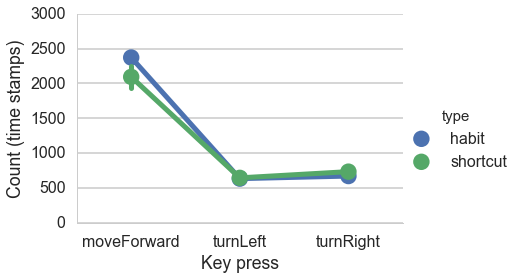

In [33]:
counts = di.merge(subj_info).groupby(['subid', 'type', 'env', 'c3']).count().reset_index()

sns.factorplot(x='c3', y='time', aspect=1.5, hue='type',
               units='subid', ci=68, data=counts)
plt.ylabel('Count (time stamps)')
plt.xlabel('Key press')

## Merge dataframes

In [34]:
dp.head()

,time,c3,subid,run,type,env,rep,trial,x,y,z
0,6525,terrain0,2,1,habit,NaN,NaN,NaN,0,0,0.0
1,6525,George_Clooney,2,1,habit,NaN,NaN,NaN,4,34,0.5
2,6525,lettuce,2,1,habit,NaN,NaN,NaN,26,52,0.5
3,6525,zebra,2,1,habit,NaN,NaN,NaN,20,22,0.5
4,6525,zzz,2,1,habit,NaN,NaN,NaN,12,52,0.2


In [35]:
dt.head()

,time,instructions,subid,run,type,env,rep,trial,total_time
0,27585,zzz,2,1,habit,env1,1,1,69860
1,97445,between_trials,2,1,habit,env1,1,1,25020
2,122465,zzz,2,1,habit,env8,1,2,35910
3,158375,between_trials,2,1,habit,env8,1,2,25010
4,183385,zzz,2,1,habit,env9,1,3,58380


In [36]:
dpt = dp.merge(dt, on=['subid', 'env', 'type', 'time', 'run', 'rep'], how='left')
dpt.ix[0,'instructions'] = 'intro'
dpt = dpt.fillna(method='ffill')
dpt.head()

,time,c3,subid,run,type,env,rep,trial_x,x,y,z,instructions,trial_y,total_time
0,6525,terrain0,2,1,habit,NaN,NaN,NaN,0,0,0.0,intro,NaN,NaN
1,6525,George_Clooney,2,1,habit,NaN,NaN,NaN,4,34,0.5,intro,NaN,NaN
2,6525,lettuce,2,1,habit,NaN,NaN,NaN,26,52,0.5,intro,NaN,NaN
3,6525,zebra,2,1,habit,NaN,NaN,NaN,20,22,0.5,intro,NaN,NaN
4,6525,zzz,2,1,habit,NaN,NaN,NaN,12,52,0.2,intro,NaN,NaN


In [37]:
dpt.query('instructions == "George_Clooney"').head()

,time,c3,subid,run,type,env,rep,trial_x,x,y,z,instructions,trial_y,total_time
41934,27860,assignmentInstruct_text,2,8,shortcut,env1,1,1,0,0,0.000000,George_Clooney,1,40750
41935,27860,assignmentInstruct_text,2,8,shortcut,env1,1,1,0,0,-1.116670,George_Clooney,1,40750
41936,27860,assignmentInstruct_text,2,8,shortcut,env1,1,1,0,0,-0.111667,George_Clooney,1,40750
41937,27860,assignmentInstruct_text,2,8,shortcut,env1,1,1,0,0,-0.083750,George_Clooney,1,40750
41938,27860,assignmentInstruct_text,2,8,shortcut,env1,1,1,0,0,-0.078750,George_Clooney,1,40750


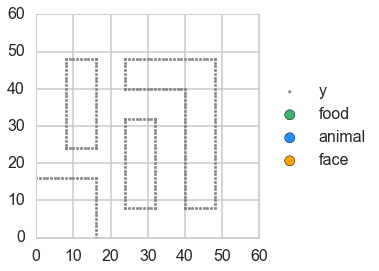

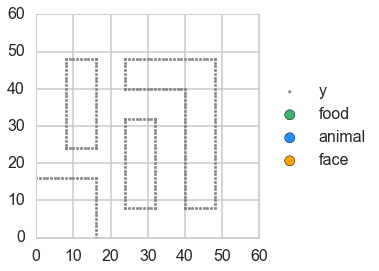

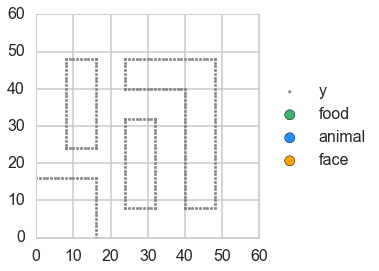

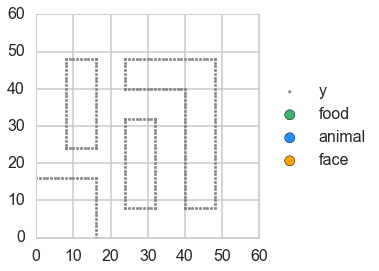

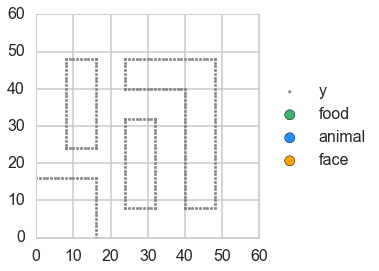

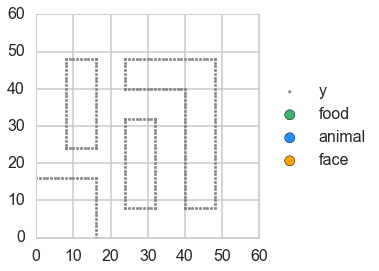

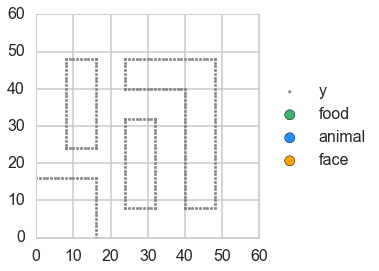

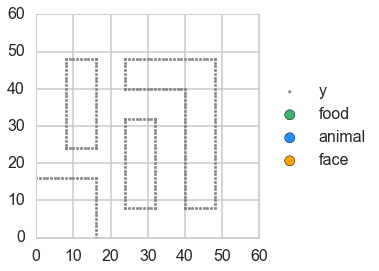

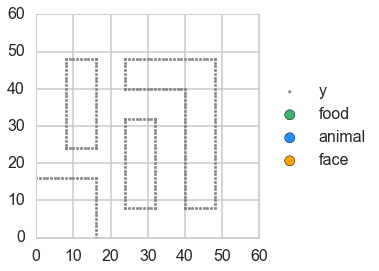

In [38]:
for i, sub in enumerate(subj_info.subid):
    fig, ax = plot_path('env1', sub, 'zebra', dpt, proj, dp)

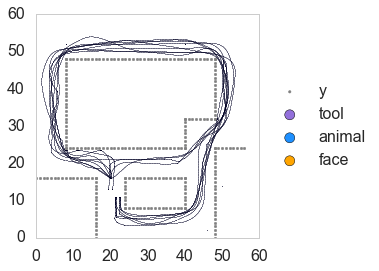

In [39]:
plot_paths_group('env3', subj_info.subid, 
                 dpt.query('type == "habit"'), proj, dp)
plt.grid(0)

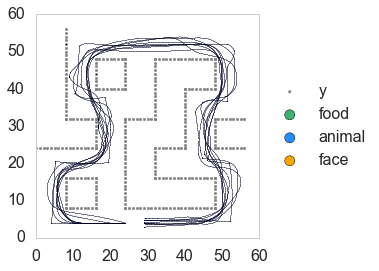

In [40]:
plot_paths_group('env12', subj_info.subid, 
                 dpt.query('type == "habit"'), proj, dp)
plt.grid(0)

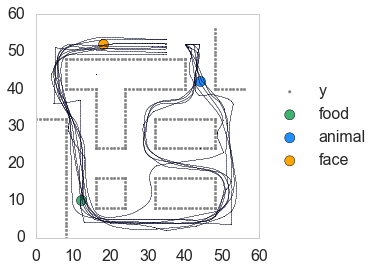

In [41]:
plot_paths_group('env10', subj_info.subid, 
                 dpt.query('type == "habit"'), proj, dp)
plt.grid(0)

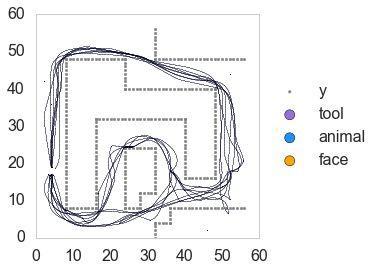

In [42]:
plot_paths_group('env9', subj_info.subid, 
                 dpt.query('type == "shortcut"'), proj, dp)
plt.grid(0)

## Navigation durations

In [43]:
dpnavdur = pd.read_csv('/Volumes/group/awagner/sgagnon/SST/analysis/nav/group_nav_durations.csv')

In [44]:
orient_onsets.head()

,index,time,c2,command,c3,c4,c5,c6,c7,c8,subid,run,type,trial,rep,env
0,224,16545,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit,1,1,1
1,15045,111425,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit,2,1,8
2,22741,172355,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit,3,1,9
3,38400,16177,21,ORIENT,oriented_to_env,,,None,None,None,2,2,habit,1,1,10
4,48755,87177,11,ORIENT,oriented_to_env,,,None,None,None,2,2,habit,2,1,2


In [49]:
dpnavdur['trial'] = np.nan

for i in dpnavdur.index:
    if i == 0:
        dpnavdur.ix[i, 'trial'] = 1
        prev_i = i
    else:
        if dpnavdur.ix[i, 'run'] == dpnavdur.ix[prev_i, 'run']:
            dpnavdur.ix[i, 'trial'] = dpnavdur.ix[prev_i, 'trial'] + 1
            prev_i = i
        else:
            dpnavdur.ix[i, 'trial'] = 1
            prev_i = i
            
dpnavdur.head()

,time,command,subid,run,duration,trial
0,19.26,NAVIGATE,2,1,61.88,1
1,114.14,NAVIGATE,2,1,27.93,2
2,175.07,NAVIGATE,2,1,50.39,3
3,19.25,NAVIGATE,2,2,38.02,1
4,90.26,NAVIGATE,2,2,32.36,2


In [57]:
dpnavdur.subid = dpnavdur.subid.astype('str')
dp_nav = dpnavdur.merge(orient_onsets, 
               on=['subid', 'run', 'trial']).drop(['index', 'time_y', 'c2', 'command_y',
                                                   'c3', 'c4', 'c5', 'c6',
                                                   'c7', 'c8'], axis=1)

In [58]:
dp_nav.head()

,time_x,command_x,subid,run,duration,trial,type,rep,env
0,19.26,NAVIGATE,2,1,61.88,1,habit,1,1
1,114.14,NAVIGATE,2,1,27.93,2,habit,1,8
2,175.07,NAVIGATE,2,1,50.39,3,habit,1,9
3,19.25,NAVIGATE,2,2,38.02,1,habit,1,10
4,90.26,NAVIGATE,2,2,32.36,2,habit,1,2


In [63]:
min_navtimes.head()

,type,env,rep,time_x,command_x,subid,run,duration,trial
0,habit,1,1,19.222,NAVIGATE,11,1,39.895,1
1,habit,2,1,90.260,NAVIGATE,11,1,29.220,2
2,habit,3,1,164.608,NAVIGATE,11,1,28.609,3
3,habit,4,1,19.218,NAVIGATE,11,1,34.875,1
4,habit,5,1,87.100,NAVIGATE,11,1,44.515,2


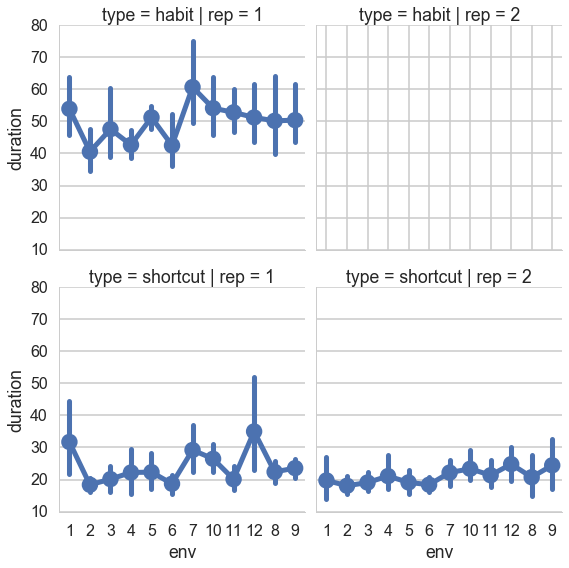

In [67]:
min_navtimes = dp_nav.groupby(['subid', 'type', 'env', 'rep']).min().reset_index()
sns.factorplot(x='env', y='duration', col='rep', row='type', 
               units='subid', data=min_navtimes)

In [71]:
dp_nav.groupby(['subid']).min().reset_index()

,subid,time_x,command_x,run,duration,trial,type,rep,env
0,11,19.200,NAVIGATE,1,13.580,1,habit,1,1
1,12,19.179,NAVIGATE,1,17.190,1,habit,1,1
2,2,19.190,NAVIGATE,1,14.430,1,habit,1,1
3,3,19.200,NAVIGATE,1,15.840,1,habit,1,1
4,4,19.180,NAVIGATE,1,12.390,1,habit,1,1
5,5,19.190,NAVIGATE,1,13.380,1,habit,1,1
6,6,19.231,NAVIGATE,1,12.080,1,habit,1,1
7,7,19.220,NAVIGATE,1,12.940,1,habit,1,1
8,9,19.178,NAVIGATE,1,11.906,1,habit,1,1


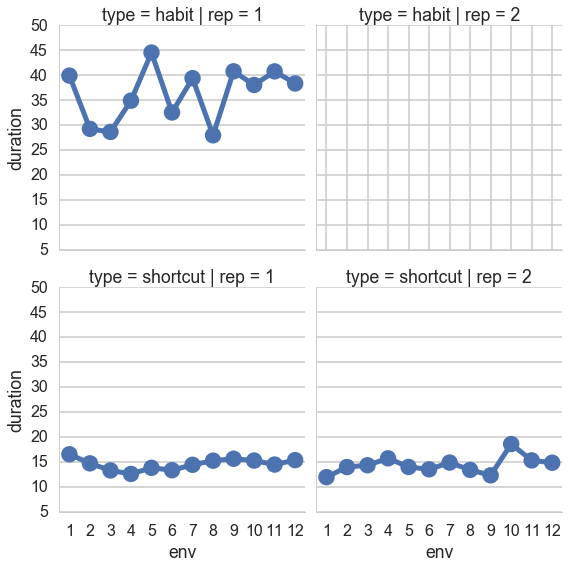

In [69]:
min_navtimes = dp_nav.groupby(['type', 'env', 'rep']).min().reset_index()
min_navtimes.drop(['time_x', 'command_x', 'subid', 'run', 'trial'], axis=1).to_csv('/Volumes/group/awagner/sgagnon/SST/analysis/nav/min_nav_durations.csv')
sns.factorplot(x='env', y='duration', col='rep', row='type', data=min_navtimes)

## Code to figure out how many subjects took shortcuts:

In [126]:
data_test = dpt #.query('type != "habit"')
rep_types = [1, 2]
trial_types = ['habit', 'shortcut']

total_subjs = len(data_test.subid.unique())

dshortcuts = pd.DataFrame(columns=['subid', 'env', 'rep', 'trial_type', 'shortcuts'])
for env in proj['envs']:
    sc = shortcut_coords[shortcut_coords.env==env]
    for rep in rep_types:
        for trial_type in trial_types:
            for sub in subj_info.subid:
                subs= data_test[(data_test.subid == sub) &
                                (data_test.c3 == 'PandaEPL_avatar') &
                                (data_test.instructions != 'between_trials') &
                                (data_test.rep == rep) &
                                (data_test['type'] == trial_type) &
                                (data_test.env == env) &
                                (data_test.x < sc.x_hi.values[0]) & 
                                (data_test.x > sc.x_lo.values[0]) & 
                                (data_test.y < sc.y_hi.values[0]) &
                                (data_test.y > sc.y_lo.values[0])].subid.unique()

                row = {'subid': sub,
                       'env': env, 
                       'rep': rep, 
                       'trial_type': trial_type,
                       'shortcuts': len(subs)}
                dshortcuts = dshortcuts.append(row, ignore_index=True)

In [127]:
dshortcuts.head()

,subid,env,rep,trial_type,shortcuts
0,2,env1,1,habit,0
1,3,env1,1,habit,0
2,4,env1,1,habit,0
3,5,env1,1,habit,0
4,6,env1,1,habit,0


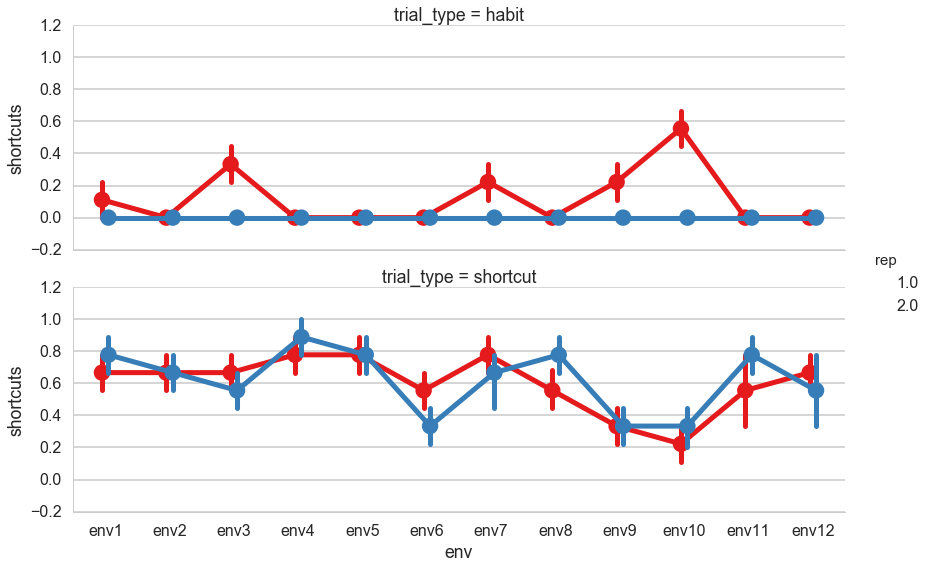

In [128]:
sns.factorplot(x='env', y='shortcuts', 
               row='trial_type',
               units='subid', ci=68,
               aspect=3, hue='rep',
               dodge=.1,
               data=dshortcuts, 
               palette='Set1')

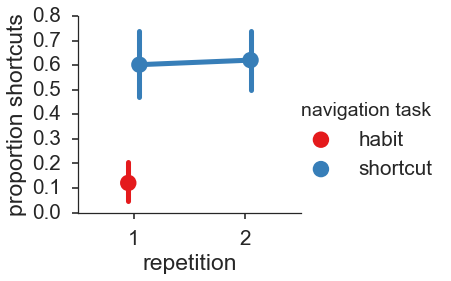

In [142]:
data = dshortcuts.groupby(['subid', 'rep', 'trial_type']).mean().reset_index()
data.rep = data.rep.astype(int)
sns.set(style='ticks', context='poster', font_scale=1.3)
data['navigation task'] = data.trial_type
data.loc[(data.rep == 2) & 
         (data.trial_type == 'habit'), 'shortcuts'] = np.nan
sns.factorplot(x='rep', y='shortcuts', 
               hue='navigation task',
               units='subid',
               dodge=.1,
               aspect=1.2,
               data=data.reset_index(),
               palette='Set1')
plt.ylabel('proportion shortcuts')
plt.xlabel('repetition')
# plt.tight_layout()

plt.savefig('/Volumes/group/awagner/sgagnon/SST/analysis/behav/proportion_shortcut.png')

In [156]:
data = dshortcuts[dshortcuts.trial_type == 'shortcut']
data = data.groupby(['rep']).mean().reset_index()
data

,rep,shortcuts
0,1,0.601852
1,2,0.620370


  subid  rep  shortcuts
0    11    1   0.250000
1    11    2   0.500000
2    12    1   0.500000
3    12    2   0.250000
4     2    1   0.416667


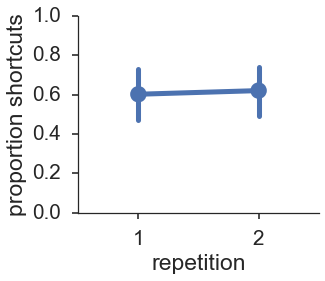

In [152]:
data = dshortcuts[dshortcuts.trial_type == 'shortcut']
data = data.groupby(['subid', 'rep']).mean().reset_index()
data.rep = data.rep.astype(int)
print data.head()
sns.set(style='ticks', context='poster', font_scale=1.3)
# data['navigation task'] = data.trial_type
#data.loc[(data.rep == 2) & 
#         (data.trial_type == 'habit'), 'shortcuts'] = np.nan
sns.factorplot(x='rep', y='shortcuts', 
               #hue='navigation task',
               units='subid',
               dodge=.1,
               aspect=1.2,
               data=data)
plt.ylabel('proportion shortcuts')
plt.xlabel('repetition')
plt.ylim(0,1)
# plt.tight_layout()

plt.savefig('/Volumes/group/awagner/sgagnon/SST/analysis/behav/proportion_shortcut_v2.png')

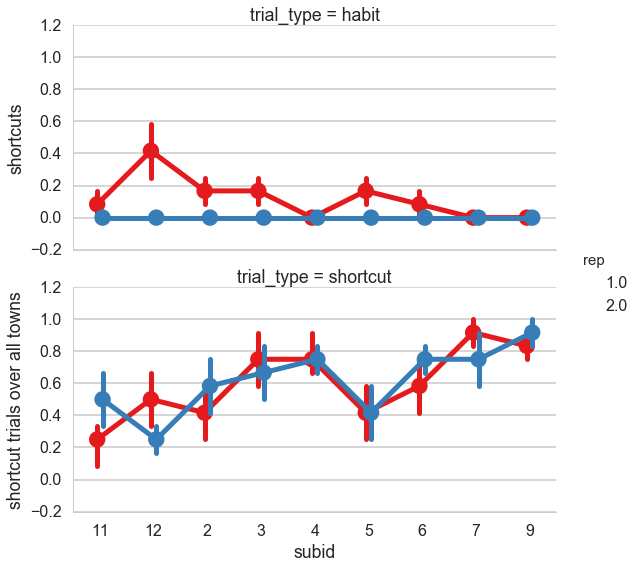

In [131]:
data = dshortcuts.groupby(['subid', 'env', 'rep', 'trial_type']).mean()
sns.factorplot(x='subid', y='shortcuts', hue='rep', ci=68,
               row='trial_type',
               units='env',
               dodge=.1, aspect=2, palette='Set1',
               data=data.reset_index())
plt.ylabel('shortcut trials over all towns')

In [132]:
pd.pivot_table(data.reset_index(), index=['rep', 'trial_type'])

shortcuts
rep trial_type           
1   habit        0.120370
    shortcut     0.601852
2   habit        0.000000
    shortcut     0.620370

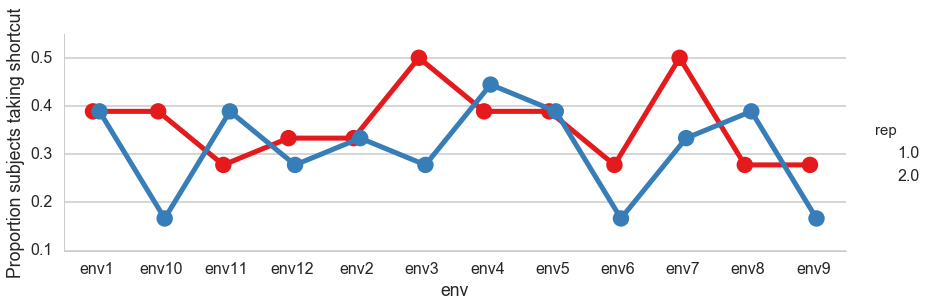

In [133]:
data = dshortcuts.groupby(['env', 'rep']).mean()
sns.factorplot(x='env', hue='rep', y='shortcuts', 
               dodge=.1, aspect=3,
               palette='Set1',
               data=data.reset_index())
plt.ylabel('Proportion subjects taking shortcut')

<module 'matplotlib.pyplot' from '/Users/sgagnon/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

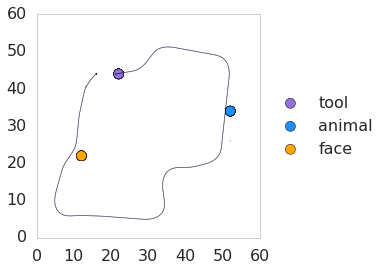

In [177]:
plot_paths('env4', '2', 
           dp[dp.test_trial == 'training'], proj)
plt.grid(0)
plt

<module 'matplotlib.pyplot' from '/Users/sgagnon/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

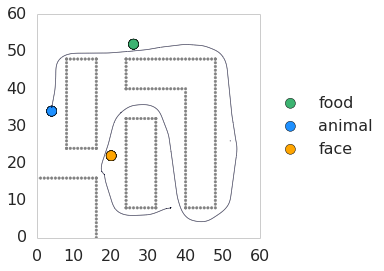

In [225]:
plot_paths('env1', '7', 
           dp[dp.test_trial == 'test2'], proj)
plt.grid(0)
plt

<module 'matplotlib.pyplot' from '/Users/sgagnon/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

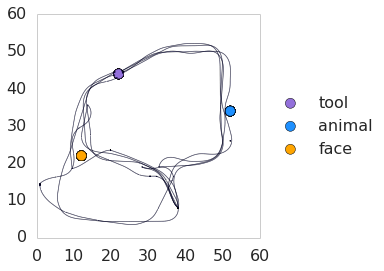

In [180]:
plot_paths_group('env4', subj_info.subid, 
                 dpt.query('test_trial == "test2"'), proj, dp)
plt.grid(0)
plt

## Correlation of shortcuts with trait measures

In [228]:
data = dshortcuts.groupby(['subid', 'rep']).mean().reset_index()
data = data.merge(dq_post, on='subid')

In [229]:
data.head()

,subid,rep,shortcuts,compass,generalSOD,landmark,route,survey,surveySpatial,verbalSpatial,survey_pref
0,11,1,0.250000,4,11,8,8,5,4,3,-3
1,11,2,0.583333,4,11,8,8,5,4,3,-3
2,2,1,0.416667,9,18,8,8,8,4,2,0
3,2,2,0.583333,9,18,8,8,8,4,2,0
4,3,1,0.750000,11,19,6,3,8,3,4,2


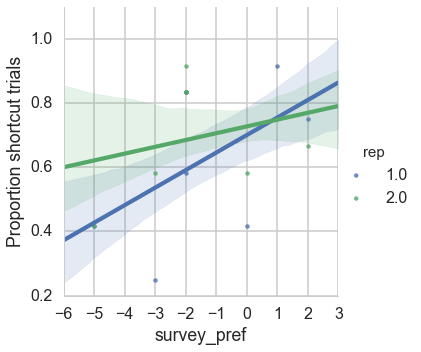

In [230]:
sns.lmplot(x='survey_pref', hue='rep', y='shortcuts', ci=68, 
           data=data)
plt.ylabel('Proportion shortcut trials')

In [169]:
%R -i data

In [174]:
%%R 
print(str(data))
contrasts(data$test_num) = c(-1,1)
print(contrasts(data$test_num))
print(summary(lm(shortcuts ~ scale(survey_pref) + test_num, data=data)))

'data.frame':	16 obs. of  11 variables:
 $ subid        : Factor w/ 8 levels "1","2","3","4",..: 1 1 2 2 3 3 4 4 5 5 ...
 $ test_num     : Factor w/ 2 levels "test1","test2": 1 2 1 2 1 2 1 2 1 2 ...
 $ shortcuts    : num [1:16(1d)] 0.417 0.833 0.417 0.417 0.333 ...
 $ compass      : int [1:16(1d)] 6 6 5 5 5 5 7 7 5 5 ...
 $ generalSOD   : int [1:16(1d)] 11 11 12 12 15 15 16 16 10 10 ...
 $ landmark     : int [1:16(1d)] 10 10 10 10 8 8 9 9 8 8 ...
 $ route        : int [1:16(1d)] 8 8 8 8 8 8 8 8 2 2 ...
 $ survey       : int [1:16(1d)] 6 6 5 5 4 4 7 7 2 2 ...
 $ surveySpatial: int [1:16(1d)] 5 5 4 4 2 2 4 4 5 5 ...
 $ verbalSpatial: int [1:16(1d)] 3 3 2 2 5 5 3 3 1 1 ...
 $ survey_pref  : int [1:16(1d)] -4 -4 -5 -5 -4 -4 -2 -2 -6 -6 ...
NULL
      [,1]
test1   -1
test2    1

Call:
lm(formula = shortcuts ~ scale(survey_pref) + test_num, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.29113 -0.10881  0.01321  0.11252  0.24758 

Coefficients:
                   Es

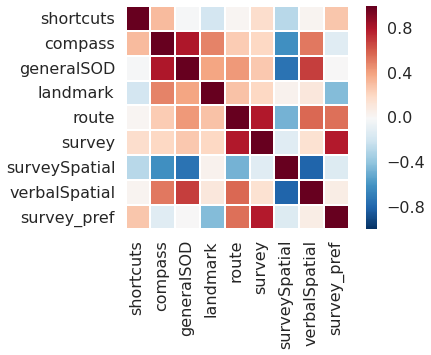

In [109]:
data = dshortcuts.groupby(['subid']).mean().reset_index()
data = data.merge(dq_post, on='subid')

dsub = data.ix[:,1:].T
sns.heatmap(np.corrcoef(dsub), 
            xticklabels=dsub.index,
            yticklabels=dsub.index,
            square=True)

## Calculate Path Lengths

In [61]:
dpt.head()

,time,c3,subid,env,test_trial,x,y,z,instructions,total_time
0,6656,terrain,1,env1,training,0,0,0.0,intro,NaN
1,6656,zebra,1,env1,training,4,34,0.5,intro,NaN
2,6656,lettuce,1,env1,training,26,52,0.5,intro,NaN
3,6656,George_Clooney,1,env1,training,20,22,0.5,intro,NaN
4,6656,zzz,1,env1,training,12,52,0.2,intro,NaN


In [62]:
dplen = pd.DataFrame(columns=['subid', 'env', 'goal_type', 'path_len'])

for env in proj['envs']:
    goals = set(dpt[dpt.env == env].instructions)
    goals.discard('between_trials')
    goals.discard('intro')

    for subid in subj_info.subid:
#         print subid
        
        for goal in goals:
#             print goal

            goal_type = dict((v,k) for k,v in proj['goals'][env].items()).get(goal)
#             print goal_type
            data_sub = dpt[(dpt.subid == subid) & (dpt.env == env) & 
                           (dpt.instructions == goal) & 
                           (dpt.c3 == 'PandaEPL_avatar')]
            distance = sp.spatial.distance.euclidean(data_sub.x, data_sub.y)
            
            row = pd.Series({'subid': subid,
                             'env': env,
                             'goal_type': goal_type,
                             'path_len': distance})
            dplen = dplen.append(row, ignore_index=True)

In [63]:
dplen.head()

,subid,env,goal_type,path_len
0,1,env1,None,1259.605132
1,1,env1,animal,839.519945
2,2,env1,None,1231.693554
3,2,env1,animal,1530.083381
4,3,env1,None,1279.596593


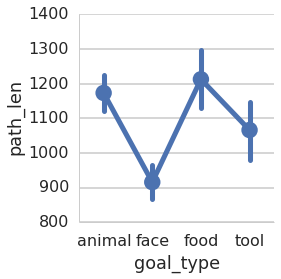

In [64]:
means = dplen.merge(subj_info).groupby(['subid', 'goal_type']).mean().reset_index()

sns.factorplot(x='goal_type', y='path_len', 
               units='subid', ci=68, dodge=.1,
               data=means)

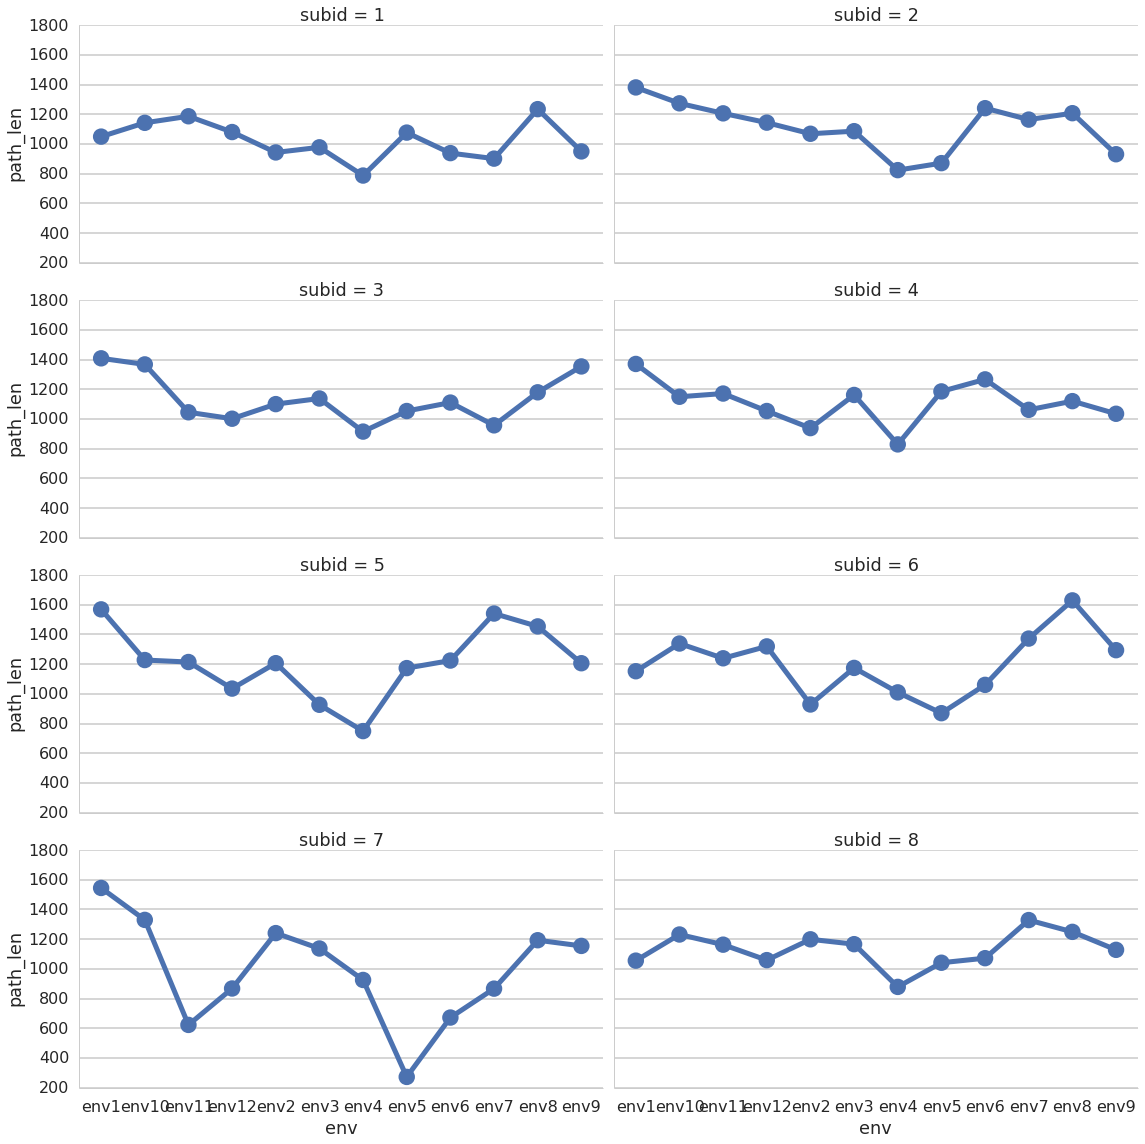

In [65]:
means = dplen.merge(subj_info).groupby(['subid', 'env']).mean().reset_index()

sns.factorplot(x='env', y='path_len', aspect=2,
               col='subid', col_wrap=2,
               dodge=.1,
               data=means)

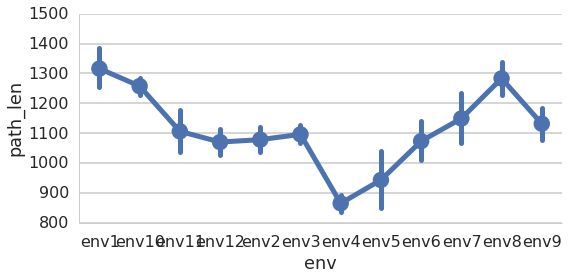

In [66]:
means = dplen.merge(subj_info).groupby(['subid', 'env']).mean().reset_index()

sns.factorplot(x='env', y='path_len', aspect=2,
               units='subid', ci=68, dodge=.1,
               data=means, )